In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Circle
import time
from itertools import islice
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from itertools import groupby
from operator import itemgetter
import json 

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)


steps = 10000

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("device is:", device)

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

#torch.set_default_tensor_type(torch.DoubleTensor)


class BioLinear2D(nn.Module):

    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1, out_ring=False):
        super(BioLinear2D, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold
        self.out_fold = out_fold
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0

        #compute in_cor, shape: (in_dim_sqrt, in_dim_sqrt)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        in_dim_sqrt = int(np.sqrt(in_dim_fold))
        out_dim_sqrt = int(np.sqrt(out_dim_fold))
        x = np.linspace(1/(2*in_dim_sqrt), 1-1/(2*in_dim_sqrt), num=in_dim_sqrt)
        X, Y = np.meshgrid(x, x)
        self.in_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)

        # compute out_cor, shape: (out_dim_sqrt, out_dim_sqrt)
        if out_ring:
            thetas = np.linspace(1/(2*out_dim_fold)*2*np.pi, (1-1/(2*out_dim_fold))*2*np.pi, num=out_dim_fold)
            self.out_coordinates = 0.5+torch.tensor(np.transpose(np.array([np.cos(thetas), np.sin(thetas)]))/4, dtype=torch.float)
        else:
            x = np.linspace(1/(2*out_dim_sqrt), 1-1/(2*out_dim_sqrt), num=out_dim_sqrt)
            X, Y = np.meshgrid(x, x)
            self.out_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)


    def forward(self, x):
        return self.linear(x)


class BioMLP2D(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP2D, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth

        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1
        linear_list = []
        for i in range(self.depth):
            if i == 0:
                # for modular addition
                #linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=2))
                # for regression
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1).to(device))
            elif i == self.depth - 1:
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1, out_ring=True).to(device))
            else:
                linear_list.append(BioLinear2D(shp[i], shp[i+1]).to(device))
        self.linears = nn.ModuleList(linear_list)


        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size)).to(device)

        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.5 # distance between two nearby layers
        self.in_perm = nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 30
        self.token_embedding = token_embedding

    def forward(self, x):
        shp = x.shape
        x = x.reshape(shp[0],-1)
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        x = x[:,:,self.in_perm.long()]
        x = x.reshape(shp[0], shp[1])
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)

        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        #x = x[:,self.out_perm]

        return x

    def get_linear_layers(self):
        return self.linears

    def get_cc(self, weight_factor=2.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i].to(device)
            dist = torch.sum(torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0)),dim=2).to(device)
            # print("yooo")
            # print(biolinear.linear.weight.device)
            # print(dist.device)
            # print(self.l0)
            cc += torch.mean(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.mean(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.mean(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc

    def swap_weight(self, weights, j, k, swap_type="out"):
        with torch.no_grad():
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))

    def swap_bias(self, biases, j, k):
        with torch.no_grad():
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp

    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron.
        # Note: n layers of weights means n+1 layers of neurons.
        # (incoming, outgoing) * weights + biases are swapped.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            return
            # for images, do not allow input_perm
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm. do not allow input_perm for images
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : (incoming, outgoing) * weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index, score

    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)

    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id[0]:
            self.relocate_ij(i,j)

    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)



/Users/zephyr/anaconda3/envs/modmi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device is: mps


In [3]:
train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)
data_size = 60000
train = torch.utils.data.Subset(train, range(data_size))
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

In [4]:
def extract_activations(layer, input, output):
    return output

activations = []

def hook_fn(module, input, output):
    activations.append(output)

hooks = []

def measure_improvement(patched_logits, original_logits):
    # Compute L2 difference
    difference_L2 = torch.norm(patched_logits - original_logits, p=2).item()
    return difference_L2

def patch_neuron(activation, neuron_idx, new_value):
    patched_activation = activation.clone()
    # print("To be patched: ", patched_activation[0, neuron_idx])
    # print("patched to:", new_value)
    patched_activation[0, neuron_idx] = new_value
    return patched_activation

def sparsify2circuit_left(wt_tensor, indices_tensor):
    zero_tensor = torch.zeros_like(wt_tensor)
    zero_tensor[indices_tensor, :] = wt_tensor[indices_tensor, :]
    return zero_tensor

def sparsify2circuit_right(wt_tensor, indices_tensor):
    zero_tensor = torch.zeros_like(wt_tensor)
    zero_tensor[:, indices_tensor] = wt_tensor[:, indices_tensor]
    return zero_tensor

def get_top_n_from_each_layer(layer_dict, n):
    # top_n = {}
    top_try = {}
    for layer in layer_dict:
        # top_n[layer] = layer_dict[layer][:n]
        top_try[layer] = [z[0][1] for z in layer_dict[layer][:n]]
    return top_try

def circuit_discovery(model, clean_tensor, corr_tensor):

    # Attach hooks to all BioLinear2D layers
    for layer in model.get_linear_layers():
        hooks.append(layer.register_forward_hook(hook_fn))

    model.eval() 
    original_output = model(clean_tensor)
    clean_activations = activations.copy()  # Store activations after passing the clean tensor
    activations.clear()
    # print(clean_activations)
    model(corr_tensor)
    corrupted_activations = activations  # Store activations after passing the corrupted tensor
    # print(corrupted_activations)

    # Clear the hooks
    for hook in hooks:
        hook.remove()

    improvements = []

    # Iterate through layers
    for layer_idx, (clean_act, corrupted_act) in enumerate(zip(clean_activations, corrupted_activations)):
        num_neurons = clean_act.shape[1]
        
        for neuron_idx in range(num_neurons):
            # Patch the neuron in the corrupted activations
            patched_act = patch_neuron(corrupted_act, neuron_idx, clean_act[0, neuron_idx])

            # Store the patched activations and keep others as-is
            current_activations = [a.clone() for a in corrupted_activations]
            current_activations[layer_idx] = patched_act
            model.eval() 

            for inn_idx, sub_layer in enumerate(model.get_linear_layers()[layer_idx+1:]):
                current_activations[layer_idx+inn_idx+1] = sub_layer(current_activations[layer_idx+inn_idx])

            improvement = measure_improvement(current_activations[-1], original_output)  # Implement measure_improvement as required
            improvements.append((layer_idx, neuron_idx, improvement))

    sorted_neurons = sorted(improvements, key=lambda x: x[2], reverse=False)
    return sorted_neurons


In [5]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)

# Create datasets for each class
class_3_dataset = [(image, label) for image, label in train_dataset if label == 3]
class_5_dataset = [(image, label) for image, label in train_dataset if label == 5]
class_6_dataset = [(image, label) for image, label in train_dataset if label == 6]
class_8_dataset = [(image, label) for image, label in train_dataset if label == 8]

class_1_dataset = [(image, label) for image, label in train_dataset if label == 1]
class_4_dataset = [(image, label) for image, label in train_dataset if label == 4]
class_7_dataset = [(image, label) for image, label in train_dataset if label == 7]
class_9_dataset = [(image, label) for image, label in train_dataset if label == 9]

# 1 3

# 4 9

# 7 9

# 1 2 3 4 5 6 7 8 9 0
# class_8_dataset = [(image, label) for image, label in train_dataset if label == 8]

# Custom dataset for paired data
class PairedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __len__(self):
        # Ensure both datasets are of the same length
        return min(len(self.dataset1), len(self.dataset2))

    def __getitem__(self, idx):
        image1, _ = self.dataset1[idx % len(self.dataset1)]
        image2, _ = self.dataset2[idx % len(self.dataset2)]
        return image1, image2

paired_dataset_1_3 = PairedDataset(class_3_dataset, class_1_dataset)
paired_dataset_4_9 = PairedDataset(class_9_dataset, class_4_dataset)
paired_dataset_7_9 = PairedDataset(class_9_dataset, class_7_dataset)
# Create the paired datasets
paired_dataset_3_8 = PairedDataset(class_3_dataset, class_8_dataset)
paired_dataset_5_6 = PairedDataset(class_5_dataset, class_6_dataset)

# Combine the paired datasets
final_dataset = paired_dataset_3_8 + paired_dataset_5_6

# Create a DataLoader for the final dataset
final_loader = DataLoader(final_dataset, batch_size=1, shuffle=True)
# loader_3_8 = DataLoader(paired_dataset_3_8, batch_size=1, shuffle=True)

final_st = paired_dataset_1_3 + paired_dataset_4_9 + paired_dataset_7_9
st_loader = DataLoader(final_st, batch_size=1, shuffle=True)


class_3_and_8_dataset = torch.utils.data.Subset(train_dataset, [i for i, (_, label) in enumerate(train_dataset) if label in [3, 8]])

# Create a DataLoader for the filtered dataset
acc_loader = DataLoader(class_3_and_8_dataset, batch_size=1, shuffle=True)

# # Example: Iterate over the DataLoader
# for i, (image1, image2) in enumerate(final_loader):
#     print(f"Batch {i}:")
#     print("Image from Class 3/5:", image1.shape)
#     print("Image from Class 6/8:", image2.shape)
#     if i == 5:  # Stop after 6 iterations for demonstration
#         break


# Actual Graphing hopefully

In [12]:
import json

# Replace 'path_to_file.json' with the path to your JSON file
file_path = 'bootstrap_results.json'

# Open the JSON file and load its contents into a Python object
with open(file_path, 'r') as file:
    data = json.load(file)

# Now 'data' is a Python object containing the data from the JSON file
print(data)

{'fivemodels/bimt.pt': {'avg_logit_diff': [1.2737224330881716, 0.18334597917278106], 'stop_time': [9.376142251491547, 0.021555709196431627], 'sparsity': [0.9859922108843537, 0.0009761369140441251]}, 'fivemodels/l1local.pt': {'avg_logit_diff': [1.7953282489763893, 0.2892961738550312], 'stop_time': [9.431681668758392, 0.032933812391417676], 'sparsity': [0.9824486819727891, 0.001331170306963688]}, 'fivemodels/l1only.pt': {'avg_logit_diff': [2.3412293231898333, 0.4927145977314583], 'stop_time': [9.433519232273103, 0.011173138722201803], 'sparsity': [0.9551209268707481, 0.00036423432236495044]}, 'fivemodels/l1swap.pt': {'avg_logit_diff': [1.9539728549098883, 0.2829784542176342], 'stop_time': [9.484722292423248, 0.011052775413489948], 'sparsity': [0.9630037074829934, 0.0010498596172144941]}, 'fivemodels/fully_dense.pt': {'avg_logit_diff': [8.943790509925615, 1.9791072316707232], 'stop_time': [9.539580059051513, 0.014945613357212752], 'sparsity': [0.8635494642857143, 1.9237710682374507e-05]}}

In [14]:
data['fivemodels/bimt.pt']['avg_logit_diff']

[1.2737224330881716, 0.18334597917278106]

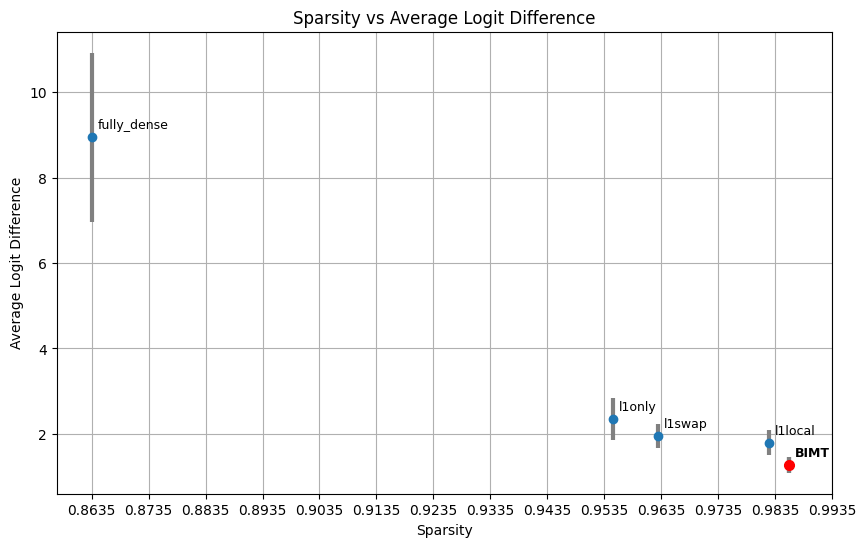

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# data = avg_results

# Extracting the values for plotting
models = list(data.keys())
avg_logit_diff_values = [data[model]['avg_logit_diff'][0] for model in models]
avg_logit_diff_errors = [data[model]['avg_logit_diff'][1] for model in models]

time_values = [data[model]['stop_time'][0]*10 for model in models]
time_errors = [data[model]['stop_time'][1]*10 for model in models]

sparsity_values = [data[model]['sparsity'][0] for model in models]
sparsity_errors = [data[model]['sparsity'][1] for model in models]

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(sparsity_values, avg_logit_diff_values, yerr=avg_logit_diff_errors, fmt='o', ecolor='gray', elinewidth=3, capsize=0)
# plt.errorbar(sparsity_values, time_values, yerr=time_errors, fmt='o', ecolor='gray', elinewidth=3, capsize=0)

# plt.errorbar([sparsity_values[0]], [time_values[0]], yerr=[time_errors[0]], fmt='o', ecolor='gray', elinewidth=3, capsize=5, color='red', markersize=10)

plt.errorbar([sparsity_values[0]], [avg_logit_diff_values[0]], yerr=[avg_logit_diff_errors[0]], fmt='o', ecolor='gray', elinewidth=3, capsize=0, color='red', markersize=7)

# Labeling
plt.xlabel('Sparsity')
plt.ylabel('Average Logit Difference')
plt.title('Sparsity vs Average Logit Difference')
plt.xticks(np.arange(min(sparsity_values), max(sparsity_values)+0.015, 0.01))
plt.grid(True)

# Annotating the models
for i, txt in enumerate(models):
    t = txt.split("/")[-1].split('.')[0]
    if t == 'bimt':
        plt.annotate("BIMT", (sparsity_values[i]+0.001, avg_logit_diff_values[i]+0.2), fontweight='bold', fontsize=9)
    else:
        plt.annotate(t, (sparsity_values[i]+0.001, avg_logit_diff_values[i]+0.2), fontweight='normal', fontsize=9)

plt.show()

## Inference Time

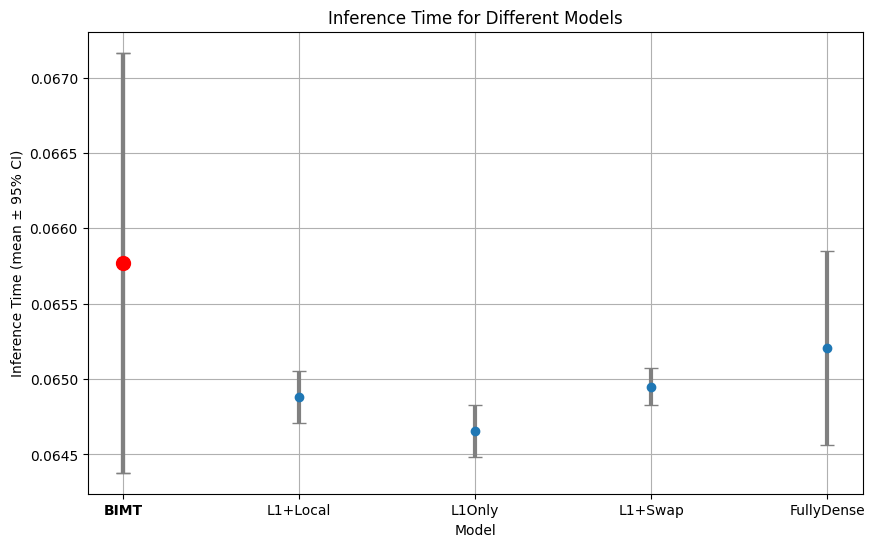

In [35]:
inference_time_data = [
    (0.06577184200286865, 0.0013927661991169052),
    (0.06488064527511597, 0.0001699680190952522),
    (0.0646560549736023, 0.00017137254463719725),
    (0.06494998931884766, 0.00012326044860905294),
    (0.06520644426345826, 0.0006449584712101988)
]

model_names = ["BIMT", "L1+Local", "L1Only", "L1+Swap", "FullyDense"]

# Extracting mean values and confidence intervals
means = [mean for mean, ci in inference_time_data]
cis = [ci for mean, ci in inference_time_data]

# Plotting
plt.figure(figsize=(10, 6))
# plt.errorbar(model_names, means, yerr=cis, fmt='o', ecolor='gray', elinewidth=3, capsize=5)

# Error bars for all points
plt.errorbar(model_names, means, yerr=cis, fmt='o', ecolor='gray', elinewidth=3, capsize=5)

# Highlight the BIMT point in red but keep the error bar gray
plt.errorbar([model_names[0]], [means[0]], yerr=[cis[0]], fmt='o', ecolor='gray', elinewidth=3, capsize=5, color='red', markersize=10)

# Making the BIMT label bold
plt.xticks(fontweight='bold')
for tick in plt.gca().get_xticklabels():
    if tick.get_text() == 'BIMT':
        tick.set_fontweight('bold')
    else:
        tick.set_fontweight('normal')

# Labeling
plt.xlabel('Model')
plt.ylabel('Inference Time (mean ± 95% CI)')
plt.title('Inference Time for Different Models')
plt.grid(True)

plt.show()

# ACt Patch graph

In [6]:
mlp = BioMLP2D(shp=(784,100,100,10)).to("cpu")
mlp.load_state_dict(torch.load("fivemodels/bimt.pt"))

<All keys matched successfully>

In [31]:
corr_ten = class_8_dataset[10][0][0]
# corr_ten= corr_ten.unsqueeze(0)
corr_ten.shape

torch.Size([28, 28])

In [22]:
train[46][0][0].detach().numpy()[:,::-1].shape

(28, 28)

In [26]:
corr_ten.detach().numpy()[:,::-1].shape

(28, 28)

0
20
40
60
80
0
20
40
60
80
0


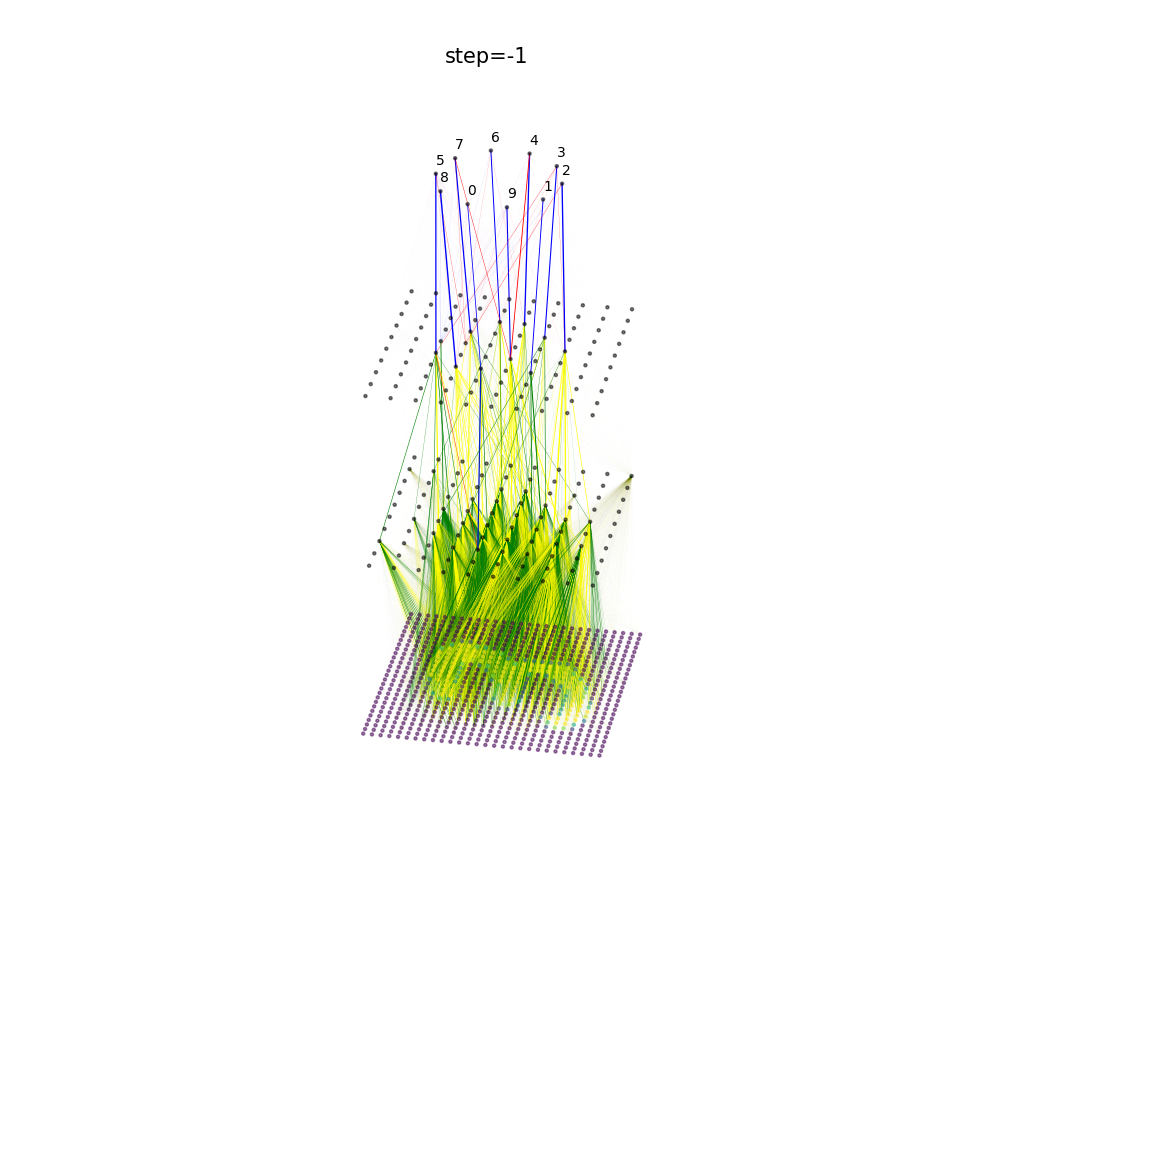

In [27]:

fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(projection='3d')
step = 0
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
ax.scatter(mlp.linears[0].in_coordinates[:,0].detach().numpy(), mlp.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=corr_ten.detach().numpy()[:,::-1].reshape(-1,))
ax.scatter(mlp.linears[1].in_coordinates[:,0].detach().numpy(), mlp.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
ax.scatter(mlp.linears[2].in_coordinates[:,0].detach().numpy(), mlp.linears[2].in_coordinates[:,1].detach().numpy(),[2]*100, s=5, alpha=0.5, color="black")
ax.scatter(mlp.linears[2].out_coordinates[:,0].detach().numpy(), mlp.linears[2].out_coordinates[:,1].detach().numpy(),[3]*10, s=5, alpha=0.5, color="black")
ax.set_zlim(-0.5,5)
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)


for ii in range(3):
    biolinear = mlp.linears[ii]
    p = biolinear.linear.weight.clone()
    # if ii == 0:
    #     p = sparsify2circuit_left(p, torch.tensor(top_10_per_group[ii]))
    # else:
    #     p = sparsify2circuit_right(p, torch.tensor(top_10_per_group[ii-1]))
    #     p = sparsify2circuit_left(p, torch.tensor(top_10_per_group[ii]))
    p_shp = p.shape
    p = p/torch.abs(p).max()

    for i in range(p_shp[0]):
        if i % 20 == 0:
            print(i)
        for j in range(p_shp[1]):
            out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
            in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
            if (ii == 1) and (j==47):
                plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=5*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")   
            if (ii == 2):
                plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")   
            else:
                plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="green" if p[i,j]>0 else "yellow")


ring = mlp.linears[2].out_coordinates.detach().cpu().numpy()
for i in range(10):
    ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(mlp.out_perm.long()[i].detach().cpu().numpy()))


ax.view_init(30,10)

ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

ax.axis('off')

# plt.savefig('./results/mnist_noswap/{0:06d}.png'.format(step-1))

plt.show()

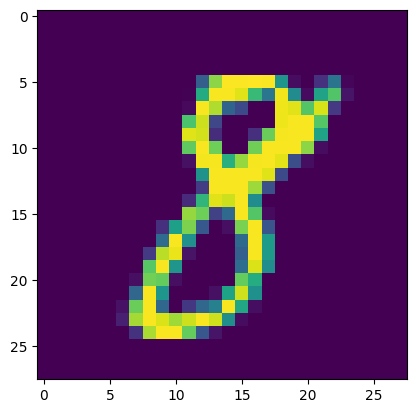

In [33]:
corr_ten = class_8_dataset[5][0][0]
plt.imshow(corr_ten)